In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding = 'SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')

In [10]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
sess = tf.InteractiveSession()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [21]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
x_image = tf.reshape(x, [-1, 28, 28, 1])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# softmax
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [22]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [23]:
saver = tf.train.Saver()
tf.global_variables_initializer().run()

In [24]:
for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.04
step 100, training accuracy 0.86
step 200, training accuracy 0.92
step 300, training accuracy 0.92
step 400, training accuracy 0.9
step 500, training accuracy 0.94
step 600, training accuracy 0.94
step 700, training accuracy 0.92
step 800, training accuracy 0.92
step 900, training accuracy 0.96
step 1000, training accuracy 0.92
step 1100, training accuracy 0.94
step 1200, training accuracy 0.96
step 1300, training accuracy 0.98
step 1400, training accuracy 0.96
step 1500, training accuracy 0.92
step 1600, training accuracy 0.98
step 1700, training accuracy 0.96
step 1800, training accuracy 0.94
step 1900, training accuracy 0.96
step 2000, training accuracy 0.98
step 2100, training accuracy 1
step 2200, training accuracy 1
step 2300, training accuracy 0.94
step 2400, training accuracy 0.98
step 2500, training accuracy 0.98
step 2600, training accuracy 0.96
step 2700, training accuracy 0.96
step 2800, training accuracy 0.94
step 2900, training accuracy 0.96

In [25]:
save_path = saver.save(sess, "model.ckpt")

In [26]:
def plot_conv_weights(weights, num_filters, input_channel = 0):
    
    # 這裡的 w 我們預計是一個 4 維的 tensor，ex. [5, 5, 1, 32]
    # 因此要先用 session 取出數值變成 ndarray
    w = sess.run(weights)
    
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    w_min = np.min(w)
    w_max = np.max(w)
    
    fig, axes = plt.subplots(num_grids, num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i < num_grids * num_grids:
            img = w[:, :, input_channel, i]
            
            ax.imshow(img, vmin = w_min, vmax=w_max, interpolation = 'nearest', cmap = 'seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

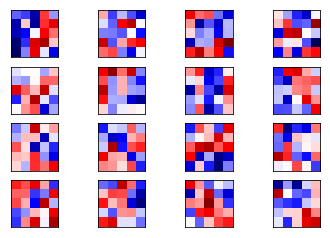

In [27]:
plot_conv_weights(W_conv1, 16)

In [28]:
def plot_conv_layer(layer, image, num_filters):
    # layer 輸入範例是 [batch_num, width, height, channels] ex. [1, 28, 28, 32]
    # 這裡設定的 image 是單一個手寫字影像輸入
    # 接下來把它餵入 tensorflow 的 session 跑出我們想要的輸出結果
    output = sess.run(layer, feed_dict = {x: [image]})
    
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    
    fig, axes = plt.subplots(num_grids, num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i < num_grids * num_grids:
            img = output[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='gray')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

In [1]:
output_conv1 = conv2d(x_image, W_conv1) + b_conv1
plot_conv_layer(output_conv1, mnist.test.images[1], 16)

NameError: name 'conv2d' is not defined

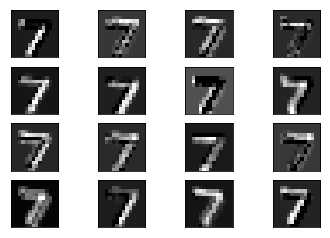

In [36]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
plot_conv_layer(h_pool1, mnist.test.images[0], 16)

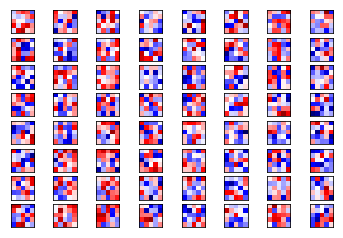

In [32]:
# 印出第二層的 weights
plot_conv_weights(W_conv2, 64)

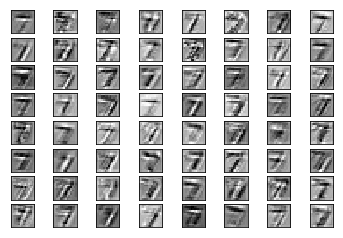

In [33]:
# 印出第二層經過過濾器的結果
plot_conv_layer(conv2d(h_pool1, W_conv2), mnist.test.images[0], 64)

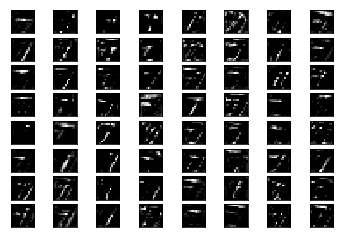

In [34]:
# 印出第二層經過 ReLU 的結果
plot_conv_layer(tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2), mnist.test.images[0], 64)

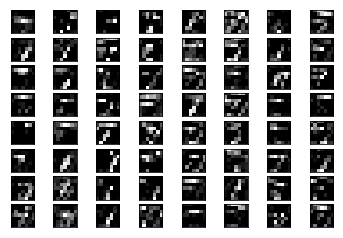

In [35]:
# 印出第二層經過 MaxPooling 的結果
plot_conv_layer(max_pool_2x2(tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)), mnist.test.images[0], 64)